In [68]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [69]:
from birdclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark()

In [70]:
root = "../data/processed/birdclef-2023/train_embeddings"
! ls {root}
! ls {root}/embeddings/*/*/*.parquet | wc -l
df = spark.read.parquet(f"{root}/embeddings/*/*/*.parquet")
df.printSchema()
df.count()

audio  consolidated_v1	embeddings
4
root
 |-- species: string (nullable = true)
 |-- track_stem: string (nullable = true)
 |-- track_type: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- predictions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- rank: long (nullable = true)
 |    |    |-- index: long (nullable = true)
 |    |    |-- label: string (nullable = true)
 |    |    |-- mapped_label: string (nullable = true)
 |    |    |-- probability: double (nullable = true)
 |-- start_time: long (nullable = true)



230

In [71]:
df.show()

+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|species|track_stem|track_type|          track_name|           embedding|         predictions|start_time|
+-------+----------+----------+--------------------+--------------------+--------------------+----------+
|abethr1|  XC128013|          |abethr1/XC128013.mp3|[-13.252567291259...|[{0, 575, Cercotr...|         0|
|abethr1|  XC128013|          |abethr1/XC128013.mp3|[-18.698907852172...|[{0, 3185, Turdus...|         3|
|abethr1|  XC128013|          |abethr1/XC128013.mp3|[-16.031141281127...|[{0, 575, Cercotr...|         6|
|abethr1|  XC128013|          |abethr1/XC128013.mp3|[-13.391376495361...|[{0, 575, Cercotr...|         9|
|abethr1|  XC128013|          |abethr1/XC128013.mp3|[-16.535093307495...|[{0, 3185, Turdus...|        12|
|abethr1|  XC128013|          |abethr1/XC128013.mp3|[-13.612257003784...|[{0, 575, Cercotr...|        15|
|abethr1|  XC128013|          |abethr1/XC12801

In [72]:
df.groupBy("track_stem").agg(F.max("start_time") + 3).show()

+----------+---------------------+
|track_stem|(max(start_time) + 3)|
+----------+---------------------+
|  XC128013|                   48|
|  XC363502|                   39|
|  XC363503|                   30|
|  XC363501|                   21|
+----------+---------------------+



In [73]:
subset = df.where("track_stem = 'XC128013' and track_type = 'source0'")
exploded = subset.select("start_time", F.explode("predictions")).select(
    "start_time", F.col("col.*")
)
exploded.show(truncate=False)

+----------+----+-----+----------------------------------------------+------------+---------------------+
|start_time|rank|index|label                                         |mapped_label|probability          |
+----------+----+-----+----------------------------------------------+------------+---------------------+
|0         |0   |575  |Cercotrichas leucophrys_Red-backed Scrub-Robin|rbsrob1     |0.30694934725761414  |
|0         |1   |344  |Batis molitor_Chinspot Batis                  |chibat1     |0.03873155638575554  |
|0         |2   |3187 |Turdus libonyana_Kurrichane Thrush            |kurthr1     |0.02262786217033863  |
|0         |3   |1000 |Dicrurus adsimilis_Fork-tailed Drongo         |fotdro5     |0.015237321145832539 |
|0         |4   |3212 |Turtur chalcospilos_Emerald-spotted Wood-Dove |eswdov1     |0.006122157908976078 |
|0         |5   |3194 |Turdus olivaceus_Olive Thrush                 |olithr2     |0.0031078236643224955|
|0         |6   |388  |Buphagus erythrorynchus

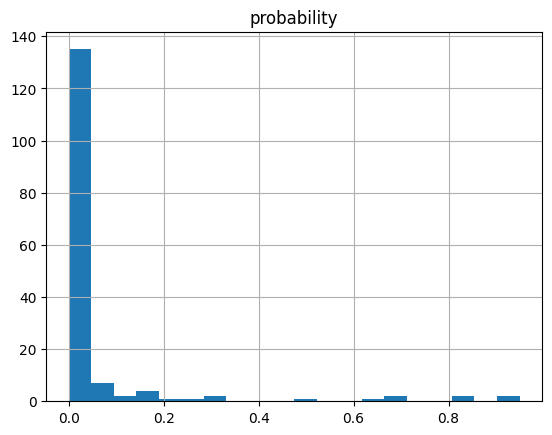

In [74]:
import matplotlib.pyplot as plt

pdf = exploded.toPandas()
pdf.hist("probability", bins=20)
plt.show()

In [75]:
exploded.where("probability > 0.1").show(truncate=False)

+----------+----+-----+----------------------------------------------+------------+-------------------+
|start_time|rank|index|label                                         |mapped_label|probability        |
+----------+----+-----+----------------------------------------------+------------+-------------------+
|0         |0   |575  |Cercotrichas leucophrys_Red-backed Scrub-Robin|rbsrob1     |0.30694934725761414|
|3         |0   |862  |Creatophora cinerea_Wattled Starling          |watsta1     |0.6403768062591553 |
|6         |0   |575  |Cercotrichas leucophrys_Red-backed Scrub-Robin|rbsrob1     |0.9385287165641785 |
|9         |0   |575  |Cercotrichas leucophrys_Red-backed Scrub-Robin|rbsrob1     |0.8250778913497925 |
|9         |1   |560  |Centropus superciliosus_White-browed Coucal   |whbcou1     |0.16167446970939636|
|12        |0   |862  |Creatophora cinerea_Wattled Starling          |watsta1     |0.20800362527370453|
|15        |0   |635  |Chloropicus fuscescens_Cardinal Woodpecke

In [82]:
indices = exploded.where("probability > 0.5")
indices.show()
start_times = indices.select("start_time").distinct().collect()
start_times = [row.start_time for row in start_times]
start_times

+----------+----+-----+--------------------+------------+------------------+
|start_time|rank|index|               label|mapped_label|       probability|
+----------+----+-----+--------------------+------------+------------------+
|         3|   0|  862|Creatophora ciner...|     watsta1|0.6403768062591553|
|         6|   0|  575|Cercotrichas leuc...|     rbsrob1|0.9385287165641785|
|         9|   0|  575|Cercotrichas leuc...|     rbsrob1|0.8250778913497925|
|        24|   0|  575|Cercotrichas leuc...|     rbsrob1|0.8414357900619507|
|        30|   0|  575|Cercotrichas leuc...|     rbsrob1|0.6680912375450134|
|        33|   0|  575|Cercotrichas leuc...|     rbsrob1|0.9496273398399353|
|        39|   0|  575|Cercotrichas leuc...|     rbsrob1|  0.51468425989151|
|        42|   0|  575|Cercotrichas leuc...|     rbsrob1|0.6718690991401672|
+----------+----+-----+--------------------+------------+------------------+



[39, 6, 9, 33, 3, 30, 42, 24]

- actual species
    - https://ebird.org/species/abethr1
    - Passeriformes Turdidae, African Bare-eyed Thrush, Turdus tephronotus
- predicted species
    - https://ebird.org/species/rbsrob1
    - Passeriformes, Muscicapidae, Red-backed Scrub-Robin, Cercotrichas leucophrys


Now let's check if this looks plausible. We're going to plot the spectogram and verify that these timeslots look correct.

In [76]:
import librosa

track_name = subset.select("track_name").first()[0]
track_path = f"{root}/audio/{track_name}"
audio, sr = librosa.load(track_path)
track_name, audio.shape, sr

('abethr1/XC128013_source0.mp3', (1058400,), 22050)

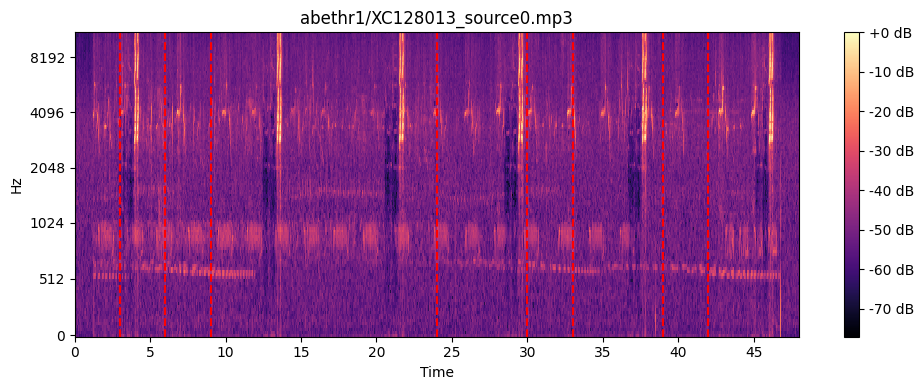

In [84]:
# plot the mel spectrogram
import librosa.display
import numpy as np

plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr, x_axis="time", y_axis="mel")
plt.title(track_name)
plt.colorbar(format="%+02.0f dB")

# draw a vertical line for each start time
for start_time in start_times:
    plt.axvline(start_time, color="r", linestyle="--")

plt.tight_layout()
plt.show()

In [85]:
# show the audio
import IPython.display as ipd

ipd.Audio(track_path, rate=sr)